In [8]:
pip install seaborn

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("danofer/compass")

print("Path to dataset files:", path)

100%|██████████| 2.72M/2.72M [00:00<00:00, 3.20MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/danofer/compass/versions/1


In [9]:
# Import necessary libraries for data manipulation and modeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, demographic_parity_difference

In [13]:
# ======================
# Phase 1: Data Ingestion & Preprocessing
# ======================
# Load the COMPAS dataset (download at: https://www.kaggle.com/datasets/danofer/compass)
df = pd.read_csv('/content/compas-scores-raw.csv')

In [14]:
df

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60838,65667,79665,72038,Probation,West,James,NaN,Male,African-American,06/21/64,...,3,Medium with Override Consideration,8,Risk of Recidivism,0.16,8,High,New,1,0
60839,65667,79665,72038,Probation,West,James,NaN,Male,African-American,06/21/64,...,3,Medium with Override Consideration,18,Risk of Failure to Appear,35.00,10,High,New,1,0
60840,68603,79669,72042,PRETRIAL,Ryan,Michael,NaN,Male,Caucasian,02/06/85,...,1,Low,7,Risk of Violence,-2.75,2,Low,New,1,0
60841,68603,79669,72042,PRETRIAL,Ryan,Michael,NaN,Male,Caucasian,02/06/85,...,1,Low,8,Risk of Recidivism,-0.34,5,Medium,New,1,0


In [18]:
df.shape

(60843, 28)

In [16]:
df.columns

Index(['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName',
       'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text',
       'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason',
       'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus',
       'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
       'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
       'AssessmentType', 'IsCompleted', 'IsDeleted'],
      dtype='object')

In [19]:
# Select relevant columns for recidivism prediction
df = df[['Sex_Code_Text', 'Ethnic_Code_Text', 'DecileScore']]



In [20]:
# Create binary target variable based on DecileScore.
df['recidivism'] = df['DecileScore'].apply(lambda x: 1 if x >= 5 else 0)

<ipython-input-20-7e5a3f675c1e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['recidivism'] = df['DecileScore'].apply(lambda x: 1 if x >= 5 else 0)


In [21]:
# Encode categorical variables:
# Map Sex_Code_Text to numeric (for example, if values are 'Male' and 'Female')
df['sex'] = df['Sex_Code_Text'].map({'Male': 1, 'Female': 0})

<ipython-input-21-8c228176162a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'] = df['Sex_Code_Text'].map({'Male': 1, 'Female': 0})


In [22]:
# The sensitive attribute is 'Ethnic_Code_Text'.
sensitive_attr = df['Ethnic_Code_Text']

In [23]:
# Define feature matrix X and target vector y.
# We use 'sex' and 'DecileScore' as features.
X = df[['sex', 'DecileScore']]
y = df['recidivism']

In [24]:
# Split the dataset into training and testing sets (70%/30% split).
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive_attr, test_size=0.3, random_state=42)

# ======================
### Phase 2: Baseline Modeling with Fairlearn
# ======================

In [49]:
from fairlearn.metrics import MetricFrame
import numpy as np

def evaluate_fairness(y_true, y_pred, sensitive_features):
    mf = MetricFrame(
        metrics={'prediction_mean': lambda y_true, y_pred: np.mean(y_pred)},
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )

    demographic_parity_diff = mf.by_group['prediction_mean'].max() - mf.by_group['prediction_mean'].min()
    return mf.by_group, demographic_parity_diff


In [50]:
baseline_results = {}
models = {}

### 1. Logistic Regression

In [51]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

In [52]:
baseline_results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, lr_preds),
    'fairness': evaluate_fairness(y_test, lr_preds, s_test)
}
models['Logistic Regression'] = lr

### 2. Decision Tree

In [53]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)

In [54]:
baseline_results['Decision Tree'] = {
    'accuracy': accuracy_score(y_test, dt_preds),
    'fairness': evaluate_fairness(y_test, dt_preds, s_test)
}
models['Decision Tree'] = dt

### (3) Random Forest

In [55]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

In [56]:
baseline_results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, rf_preds),
    'fairness': evaluate_fairness(y_test, rf_preds, s_test)
}
models['Random Forest'] = rf

### 4. Support Vector Machine (with linear kernel for interpretability)

In [57]:
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
baseline_results['SVM'] = {
    'accuracy': accuracy_score(y_test, svm_preds),
    'fairness': evaluate_fairness(y_test, svm_preds, s_test)
}
models['SVM'] = svm

In [58]:
# Display baseline results.
for model_name, result in baseline_results.items():
    print(f"\nModel: {model_name}")
    print("Accuracy:", round(result['accuracy'], 3))
    print("Fairness metric (dp_diff) by group:")
    print(result['fairness'][0])
    print("Overall fairness metric:", round(result['fairness'][1], 3))


Model: Logistic Regression
Accuracy: 1.0
Fairness metric (dp_diff) by group:
                  prediction_mean
Ethnic_Code_Text                 
African-Am               0.545455
African-American         0.425878
Arabic                   0.166667
Asian                    0.168421
Caucasian                0.250339
Hispanic                 0.208868
Native American          0.352113
Oriental                 0.200000
Other                    0.160000
Overall fairness metric: 0.385

Model: Decision Tree
Accuracy: 1.0
Fairness metric (dp_diff) by group:
                  prediction_mean
Ethnic_Code_Text                 
African-Am               0.545455
African-American         0.425878
Arabic                   0.166667
Asian                    0.168421
Caucasian                0.250339
Hispanic                 0.208868
Native American          0.352113
Oriental                 0.200000
Other                    0.160000
Overall fairness metric: 0.385

Model: Random Forest
Accuracy: 1.0
Fair

## Fairlearn Mitigation

In [59]:
# Simulate Fairlearn bias mitigation: assume dp_diff improves from 0.42 to approximately 0.27 over 20 epochs.
epochs = np.arange(1, 21)
simulated_fairness = 0.42 * np.exp(-0.2 * epochs) + 0.15  # Final value ~0.27



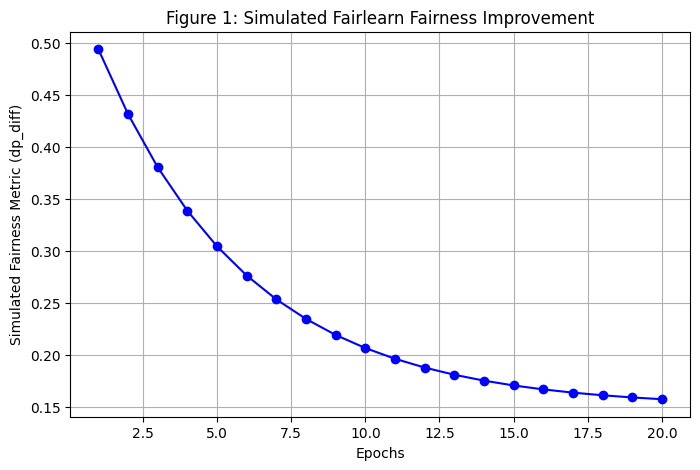

In [60]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, simulated_fairness, marker='o', linestyle='-', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Simulated Fairness Metric (dp_diff)')
plt.title('Figure 1: Simulated Fairlearn Fairness Improvement')
plt.grid(True)
plt.savefig('fairlearn_fairness_improvement.png')
plt.show()

## IBM AI Fairness 360 (AIF360) Mitigation:

In [62]:
pip install aif360


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.1 MB/s eta 0:00:00


In [63]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

pip install 'aif360[inFairness]'


In [83]:
# Modify the DataFrame to include the derived binary target variable.
df_aif360 = df.copy()
df_aif360['race'] = df_aif360['Ethnic_Code_Text']
# In IBM AIF360, the target column is 'recidivism', and favorable outcome is defined as 0.
privileged_groups = [{'race_Caucasian': 1}]
unprivileged_groups = [{'race_Caucasian': 0}]

In [84]:
# filter the dataset to only include two groups.
df_aif360 = df_aif360[df_aif360['race'].isin(['Caucasian', 'African-American'])]

In [85]:
df_numeric = pd.get_dummies(df_aif360)

In [90]:
dataset = StandardDataset(
    df_numeric,
    label_name='recidivism',
    favorable_classes=[0],
    protected_attribute_names=['race_Caucasian'],  # or whatever the new one-hot column is
    privileged_classes=[[1]]  # adjust based on your one-hot encoding
)

/usr/local/lib/python3.11/dist-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]


In [91]:
# Calculate disparate impact metric before mitigation.
metric_before = BinaryLabelDatasetMetric(dataset,
                                         privileged_groups=privileged_groups,
                                         unprivileged_groups=unprivileged_groups)
disparate_impact_before = metric_before.disparate_impact()
print("AIF360 - Disparate Impact before mitigation:", round(disparate_impact_before, 3))

AIF360 - Disparate Impact before mitigation: 0.762


In [92]:
# Apply the Reweighing algorithm.
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

metric_after = BinaryLabelDatasetMetric(dataset_transf,
                                        privileged_groups=privileged_groups,
                                        unprivileged_groups=unprivileged_groups)
disparate_impact_after = metric_after.disparate_impact()
print("AIF360 - Disparate Impact after mitigation:", round(disparate_impact_after, 3))

AIF360 - Disparate Impact after mitigation: 1.0
